In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
 pd.set_option('display.max_rows', 50)

# Analysis

The data set provides a weighting for people (ELE_G_POND_ESC) and trips (ELE_G_POND_ESC2) that allows us to make representative statements on the Madrid population from the sample data. All results take the given weights into account.

This is a descriptive analysis on different aspects of gender differences within the mobility data set of Madrid. We look at the following aspects:

- distance travelled
- trip count
- trip motive
- modal split
- speed
- legs
- time of day
- main activity (occupation)


**load data**

(for more info on data preprocessing see the  00_setup notebook)

In [3]:
# load data
df = pd.read_csv(r'..\data\processed\trips_custom_variables.csv', dtype = {'VORIHORAINI':str, 'VDESHORAFIN':str}, parse_dates = ['start_time','end_time'])

## distance

**weight by ELE_G_POND_ESC2 (weight of trip)**

In [4]:
# weighted average distance by sex
df["weighted_dist"] = df.DISTANCIA_VIAJE * df.ELE_G_POND_ESC2

# get the weighted mean distance
df_sex_sum = df.groupby("sex").sum()
df_sex_sum.weighted_dist / df_sex_sum.ELE_G_POND_ESC2 

sex
Man      7.887399
Woman    6.419492
dtype: float64

Men travel on average 7.8 km, women only 6.4 km.

## amount of trips

**weighted by ELE_G_POND (weight of individual)**

In [5]:
# weighted average amount or trips by sex
df_ind = df.groupby(["ID_HOGAR", "ID_IND", "sex"]).ELE_G_POND.agg(['mean', 'sum'])
df_ind_sex_sum = df_ind.groupby("sex").sum()
df_ind_sex_sum['sum'] / df_ind_sex_sum['mean']

sex
Man      2.641541
Woman    2.682569
dtype: float64

Men do on average 2.64 trips per day, women 2.68. Unlike the literature suggests there is no major difference. Do dip deeper, we will look at the average trips by age next:

<AxesSubplot:xlabel='rounded_age'>

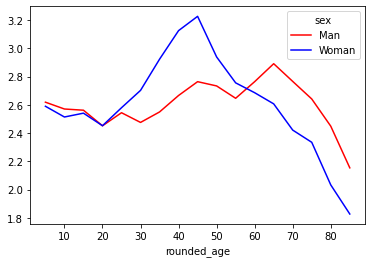

In [6]:
# weighted average amount or trips by sex

# weighted trip count each individual
trips_by_ind = df.groupby(["ID_HOGAR", "ID_IND", "sex", "rounded_age"]).ELE_G_POND.agg(['mean', 'sum'])

# group by age
trips_by_age = trips_by_ind.reset_index().groupby(["sex", "rounded_age"]).sum().reset_index()
# remove over 90 year olds (too few people)
trips_by_age = trips_by_age[trips_by_age.rounded_age < 90]
# calc weighted trip cound for each age and gender
trips_by_age["weighted_tripcount"] = trips_by_age['sum'] / trips_by_age['mean']

# plot
trips_by_age = trips_by_age.pivot(index='rounded_age', columns='sex', values='weighted_tripcount')
trips_by_age.sort_index().plot(kind = "line", color = ["red", "blue"] )

Disaggreagted by age we see that women between 25 and 55 do a lot more trips than men. After that it switches and men do more trips. 

We hypothesize that middle aged women do more trips because they do more care trips especially caring for underaged children. 

Therefore we'll look at the trip motive next.

## trip motive

**Average trip count per person by gender and motive**

trip motives have been aggregated. Original questionaire was more fine granular.

(see 00_setup notebook for details)

In [7]:
df_ind = df.loc[:,["ID_HOGAR", "ID_IND", "sex", "rounded_age", "ELE_G_POND"]].drop_duplicates()

**Average amount of trips by age and motive for men**

<AxesSubplot:xlabel='rounded_age'>

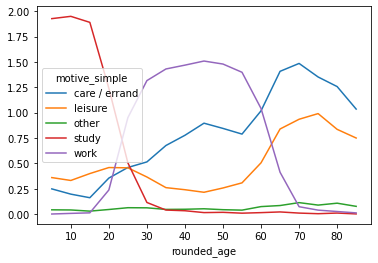

In [8]:
sum_people_by_age = df_ind.loc[df.sex == "Man"].groupby(["rounded_age"]).agg({"ELE_G_POND": "sum"}).reset_index()
sum_people_by_age.rename(columns = {'ELE_G_POND': 'people_count'}, inplace = True)

t_age = df.loc[df.sex == "Man"].groupby(["rounded_age", "motive_simple"]).agg({"ELE_G_POND_ESC2": "sum"}).reset_index()
t_age = t_age.join(sum_people_by_age.set_index("rounded_age"), on = "rounded_age")
t_age["trips_by_person"] = t_age.ELE_G_POND_ESC2 / t_age.people_count
# remove over 90 year olds (too few people)
t_age = t_age[t_age.rounded_age < 90]
t_age = t_age.pivot(index='rounded_age', columns='motive_simple', values='trips_by_person')
t_age.sort_index().plot(kind = "line")

**Average amount of trips by age and motive for women**

<AxesSubplot:xlabel='rounded_age'>

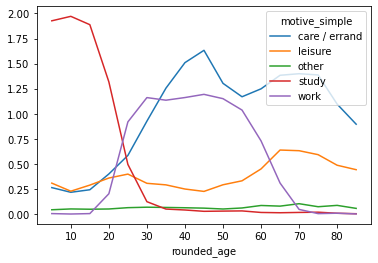

In [9]:
sum_people_by_age = df_ind.loc[df.sex == "Woman"].groupby(["rounded_age"]).agg({"ELE_G_POND": "sum"}).reset_index()
sum_people_by_age.rename(columns = {'ELE_G_POND': 'people_count'}, inplace = True)

t_age = df.loc[df.sex == "Woman"].groupby(["rounded_age", "motive_simple"]).agg({"ELE_G_POND_ESC2": "sum"}).reset_index()
t_age = t_age.join(sum_people_by_age.set_index("rounded_age"), on = "rounded_age")
t_age["trips_by_person"] = t_age.ELE_G_POND_ESC2 / t_age.people_count
t_age = t_age[t_age.rounded_age < 90]
t_age = t_age.pivot(index='rounded_age', columns='motive_simple', values='trips_by_person')
t_age.sort_index().plot(kind = "line")

As we assumed, middle aged women do more care trips than men. After the age of 55 the care trips increase for men as well as their leisure trips.

In [10]:
# TODO: delete?!

**absolute weighted amount of trips (ELE_G_POND_ESC2) by gender and age**

<AxesSubplot:xlabel='rounded_age'>

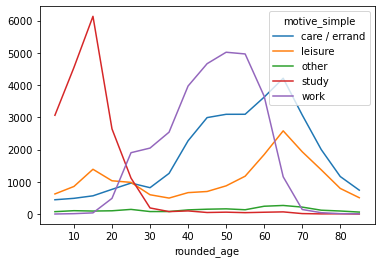

In [11]:
# amount of trips by purpose by age and sex
t_age = df.loc[df.sex == "Man"].groupby(["rounded_age", "motive_simple"]).agg({"ELE_G_POND_ESC2": "count"}).reset_index()
t_age = t_age[t_age.rounded_age < 90]
t_age = t_age.pivot(index='rounded_age', columns='motive_simple', values='ELE_G_POND_ESC2')
t_age.sort_index().plot(kind = "line")

<AxesSubplot:xlabel='rounded_age'>

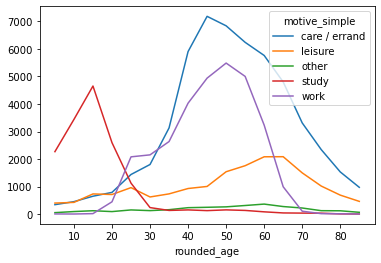

In [12]:
# weighted amount of trips by purpose by age and sex
t_age = df.loc[df.sex == "Woman"].groupby(["rounded_age", "motive_simple"]).agg({"ELE_G_POND_ESC2": "count"}).reset_index()
t_age = t_age[t_age.rounded_age < 90]
t_age = t_age.pivot(index='rounded_age', columns='motive_simple', values='ELE_G_POND_ESC2')
t_age.sort_index().plot(kind = "line")

**weighted percentage of trips purposes**

In [13]:
sum_of_weighted_trips = pd.DataFrame(df.groupby(["age_group", "sex"]).sum()).reset_index()[["age_group", "sex","ELE_G_POND_ESC2"]]

weighted_trips = df.groupby(["age_group", "sex", "motive_simple"]).sum().reset_index().set_index(["age_group", "sex"])[["motive_simple", "ELE_G_POND_ESC2"]]
weighted_trips = weighted_trips.join(sum_of_weighted_trips.set_index(["age_group", "sex"]), rsuffix = "_total")

weighted_trips["perc"] = weighted_trips.ELE_G_POND_ESC2 / weighted_trips.ELE_G_POND_ESC2_total * 100

weighted_trips.sort_values(["age_group", "sex", "perc"]).head()

motive_simple  ELE_G_POND_ESC2  ELE_G_POND_ESC2_total  \
age_group sex                                                          
adults    Man          study     5.645363e+04           3.340948e+06   
          Man          other     6.448315e+04           3.340948e+06   
          Man        leisure     3.521747e+05           3.340948e+06   
          Man  care / errand     9.908537e+05           3.340948e+06   
          Man           work     1.876983e+06           3.340948e+06   

                    perc  
age_group sex             
adults    Man   1.689749  
          Man   1.930085  
          Man  10.541162  
          Man  29.657861  
          Man  56.181144

## modal split

**modal split by aggregated modes**

the original questionaire has more fine granular modes. We summarized modes into more generic categories.

(see 00_setup notebook for details)

In [14]:
# modal split men weighted
modes_weighted = df[df.sex == 'Man'].groupby(["mode_simple"]).sum()
modes_sex_sum = modes_weighted["ELE_G_POND_ESC2"].sum()
weighted_modes = pd.DataFrame(modes_weighted['ELE_G_POND_ESC2'] / modes_sex_sum).reset_index()
weighted_modes

,mode_simple,ELE_G_POND_ESC2
0,car,0.439187
1,other,0.027688
2,public transport,0.220380
3,walk,0.312744


In [15]:
# modal split women weighted
modes_weighted = df[df.sex == 'Woman'].groupby(["mode_simple"]).sum()
modes_sex_sum = modes_weighted["ELE_G_POND_ESC2"].sum()
weighted_modes = pd.DataFrame(modes_weighted['ELE_G_POND_ESC2'] / modes_sex_sum).reset_index()
weighted_modes

,mode_simple,ELE_G_POND_ESC2
0,car,0.354988
1,other,0.006683
2,public transport,0.274191
3,walk,0.364139


Men use the car more often (44% vs. women 35%) while women use the public transport (27% vs. 22% men) and walk (36% vs. 31% men) more often than men. 

## speed

speed is computed using the straight-line distance and start and end time of each trip reported by participants.

In [16]:
# weighted average speed by sex
df["weighted_speed"] = df.speed * df.ELE_G_POND_ESC2

# get the weighted mean speed
df_sex_sum = df.groupby("sex").sum()
df_sex_sum.weighted_speed / df_sex_sum.ELE_G_POND_ESC2 

sex
Man      13.574981
Woman    11.087446
dtype: float64

Men are faster on average: 13.6 km/h vs 11.08 km/h.
of course the mode plays a major role with speed, so we disaggregate by mode in the next step.

**weighted pt speed**

only comparing speed of public transport trips

In [17]:
# get the weighted mean speed for public transport
df_pt_sex_sum = df.loc[df.mode_simple == "public transport", ].groupby("sex").sum()
df_pt_sex_sum.weighted_speed / df_pt_sex_sum.ELE_G_POND_ESC2 

sex
Man      12.406572
Woman    11.334209
dtype: float64

**weighted car speed**

only comparing speed of trips of cars

In [18]:
# get the weighted mean speed for public transport
df_car_sex_sum = df.loc[df.mode_simple == "car", ].groupby("sex").sum()
df_car_sex_sum.weighted_speed / df_car_sex_sum.ELE_G_POND_ESC2 

sex
Man      21.872648
Woman    19.681331
dtype: float64

**weighted walking speed**

only comparing speed of walked trips

In [19]:
# get the weighted mean speed for public transport
df_walk_sex_sum = df.loc[df.mode_simple == "walk", ].groupby("sex").sum()
df_walk_sex_sum.weighted_speed / df_walk_sex_sum.ELE_G_POND_ESC2 

sex
Man      2.541880
Woman    2.504671
dtype: float64

Only walking is the same speed for men and women. 
By car (21.9 km/h vs. 19.7 km/h) and public transport (12.4 km/h vs. 11.33 km/h) men move faster.
Though we need to be careful with this conclusion: as women also do shorter trips on average and longer trips are likely to be faster on average we need to correct for distance. See notebook `02_ModelPTspeed` on this.

### legs (etapas)

does the trip consist of multiple legs? Especially for public transfers this is interesting, as every leg indicates one transfer.

If the public transport network is not accounting as much for female needs as it is for male needs, the amount of transfers is one indicator. 

In [23]:
# weighted average legs for public transport

df["weighted_legs"] = df.N_ETAPAS_POR_VIAJE * df.ELE_G_POND_ESC2

df_sex_sum = df.loc[df.mode_simple == "public transport", ].groupby("sex").sum()
df_sex_sum.weighted_legs / df_sex_sum.ELE_G_POND_ESC2 

sex
Man      1.624611
Woman    1.618434
dtype: float64

Both, women and men do 1.62 legs (0.6 transfers) on average.

No evidence for a difference here.

## main activity

main activities have been aggregated (original questionaire was more fine granular).

(see 00_setup notebook for details)

In [24]:
# main activity of indivudals by sex
df.groupby(["sex"]).activity_simple.value_counts(normalize = True)

sex    activity_simple       
Man    working                   0.474748
       not working               0.279302
       student                   0.237037
       domestic and care work    0.008912
Woman  working                   0.459152
       not working               0.263013
       student                   0.162683
       domestic and care work    0.115152
Name: activity_simple, dtype: float64

### time of day

At what time of day are trips done by each gender?

In [25]:
df.loc[df.start_time.notna(), "start_hour"] = df.loc[df.start_time.notna(), "start_time"].apply(lambda x: x.hour)

<AxesSubplot:xlabel='start_hour'>

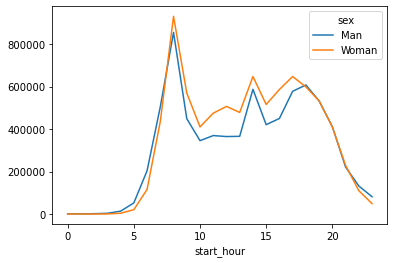

In [26]:
# weighted count of trips by sex and daytime
g = df.groupby(["sex", "start_hour"]).agg({"ELE_G_POND_ESC2": "sum"}).reset_index()
g_plot = g.pivot(index='start_hour', columns='sex', values='ELE_G_POND_ESC2')
g_plot.plot(kind = "line")

The peaks for women are not as distinct as they are for men.

To identify the origin of the peaks we disaggregate the data by main activity.

<AxesSubplot:xlabel='start_hour'>

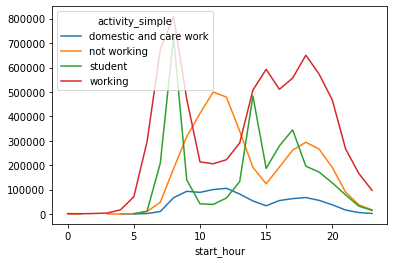

In [27]:
# weighted count of trips by main activity
g = df.groupby(["activity_simple", "start_hour"]).agg({"ELE_G_POND_ESC2": "sum"}).reset_index()

g_plot = g.pivot(index='start_hour', columns='activity_simple', values='ELE_G_POND_ESC2')

g_plot.plot(kind = "line")

gender disaggregated look onto the working people:

<AxesSubplot:xlabel='start_hour'>

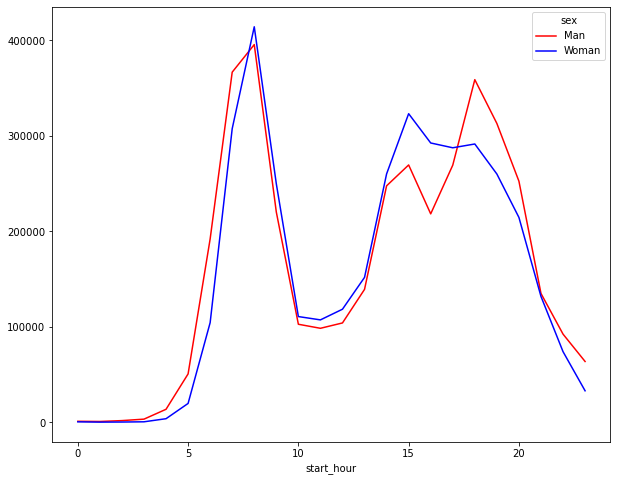

In [28]:
# weighted only working by gender
g = df[df.activity_simple == "working"].groupby(["sex", "start_hour"]).agg({"ELE_G_POND_ESC2": "sum"}).reset_index()
g_plot = g.pivot(index='start_hour', columns='sex', values='ELE_G_POND_ESC2')

g_plot.plot(kind = "line", figsize = (10,8), color = ["red", "blue"])

We see that the afternoon peak for women is earlier (3pm) while for men it is at 6 pm. 